# Objective: 
Build a model to provide an assessment of sentiments of each major US airline from twitter data. 
## Context: 
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from
February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

## Import the libraries, load dataset, print shape of data, data description

#### Import libraries

In [1]:
# Import base NLP libraries
import re, string, unicodedata
import pandas as pd
import numpy as np

# Natural language tool-kit
import nltk           

#Word Net Lemmatizer
#nltk.download('wordnet') 

# !pip install contractions
import contractions

# Beautiful soup parsing library
from bs4 import BeautifulSoup                 
from nltk import word_tokenize, sent_tokenize

# Text pre-processing libraries
from nltk.corpus import stopwords, wordnet    
from nltk.stem import LancasterStemmer, WordNetLemmatizer

from matplotlib import pyplot as plt
%matplotlib inline

#### Load dataset & print shape

In [2]:
# Import data into pandas dataframe, 14640 records of labels
data_raw = pd.read_csv('Tweets.csv')
data_raw.shape

(14640, 15)

In [3]:
# Ensure entire row is visible by truncating the text
pd.set_option('display.max_colwidth', None) 
data_raw.head().T

,0,1,2,3,4
tweet_id,570306133677760513,570301130888122368,570301083672813571,570301031407624196,570300817074462722
airline_sentiment,neutral,positive,neutral,negative,negative
airline_sentiment_confidence,1,0.3486,0.6837,1,1
negativereason,NaN,NaN,NaN,Bad Flight,Can't Tell
negativereason_confidence,NaN,0,NaN,0.7033,1
airline,Virgin America,Virgin America,Virgin America,Virgin America,Virgin America
airline_sentiment_gold,NaN,NaN,NaN,NaN,NaN
name,cairdin,jnardino,yvonnalynn,jnardino,jnardino
negativereason_gold,NaN,NaN,NaN,NaN,NaN
retweet_count,0,0,0,0,0


## Understand of data-columns

#### Drop all columns except 'text' & 'airline_sentiment'

In [4]:
data_raw.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [5]:
data_og = data_raw[['airline_sentiment', 'text']]

#### Print first 5 rows of data

In [6]:
data_og.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


#### Check the shape of data

In [7]:
# There are 14640 records
data_og.shape

(14640, 2)

In [8]:
# Check for NULL values, for which there is none
data_og.isnull().values.any()

False

In [9]:
# Show unique count of each column
data_og.nunique()

airline_sentiment        3
text                 14427
dtype: int64

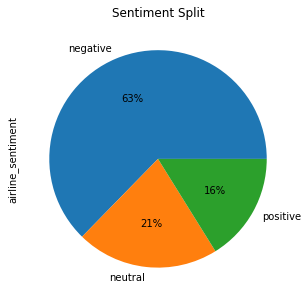

In [10]:
# Show distribution of 3 airline_sentiment classes in a Pie Chart
data_og['airline_sentiment'].value_counts(ascending=False).plot(kind='pie',autopct='%1.0f%%',figsize=(5, 5), title='Sentiment Split')

In [11]:
# Check for duplicate tweet text records, which there is 166
data_og[data_og.duplicated()]['text'].nunique()

166

## Text pre-processing: Data preparation

#### Html tag removal

In [12]:
# Create a copy of the data to work on
data = data_og.copy()

In [13]:
# Check if there are records with angle brackets for html tags, for which there is none
data[(data['text'].str.contains('<')) | (data['text'].str.contains('>'))].count()

airline_sentiment    0
text                 0
dtype: int64

In [14]:
# Function to remove html tags, if found in dataset, although this one has none
def remove_html(text):
    """Remove html tags from text"""
    bSsoup = BeautifulSoup(text, "html.parser")
    return bSsoup.get_text()

In [15]:
data['text'] = data['text'].apply(lambda x: remove_html(x))
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


#### Remove the Numbers

In [16]:
# Function to remove numbers

def remove_numbers(text):
    """Remove numbers from text"""
    pattern = r'\d+'
    text = re.sub(pattern, '', text)
    return text

In [17]:
data['text'] = data['text'].apply(lambda x: remove_numbers(x))
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials to the experience... tacky.
2,neutral,@VirginAmerica I didn't today... Must mean I need to take another trip!
3,negative,"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@VirginAmerica and it's a really big bad thing about it


#### Conversion to Lowercase & Remove Contractions

In [18]:
# Remove contractions
import contractions
data['text'] = data['text'].apply(lambda x: contractions.fix(x))

In [19]:
# Convert to lower case
data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,airline_sentiment,text
0,neutral,@virginamerica what @dhepburn said.
1,positive,@virginamerica plus you have added commercials to the experience... tacky.
2,neutral,@virginamerica i did not today... must mean i need to take another trip!
3,negative,"@virginamerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@virginamerica and it is a really big bad thing about it


#### Accented Char Removal

In [20]:
# Remove accented characters
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [21]:
data['text'] = data['text'].apply(lambda x: remove_accented_chars(x))
data.head()

,airline_sentiment,text
0,neutral,@virginamerica what @dhepburn said.
1,positive,@virginamerica plus you have added commercials to the experience... tacky.
2,neutral,@virginamerica i did not today... must mean i need to take another trip!
3,negative,"@virginamerica it is really aggressive to blast obnoxious ""entertainment"" in your guests' faces & they have little recourse"
4,negative,@virginamerica and it is a really big bad thing about it


#### Remove Special Characters & Punctuations

In [22]:
# Remove Numbers

def remove_special_characters(text):
    """Remove special characters from text"""
    pattern = r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

In [23]:
data['text'] = data['text'].apply(lambda x: remove_special_characters(x))
data.head()

,airline_sentiment,text
0,neutral,virginamerica what dhepburn said
1,positive,virginamerica plus you have added commercials to the experience tacky
2,neutral,virginamerica i did not today must mean i need to take another trip
3,negative,virginamerica it is really aggressive to blast obnoxious entertainment in your guests faces they have little recourse
4,negative,virginamerica and it is a really big bad thing about it


#### Tokenization

In [24]:
# Tokenize the words of entire dataset
for i, row in data.iterrows():
    text = data.at[i, 'text']
    words = nltk.word_tokenize(text)
    data.at[i,'text'] = words

In [25]:
data.head()

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, said]"
1,positive,"[virginamerica, plus, you, have, added, commercials, to, the, experience, tacky]"
2,neutral,"[virginamerica, i, did, not, today, must, mean, i, need, to, take, another, trip]"
3,negative,"[virginamerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guests, faces, they, have, little, recourse]"
4,negative,"[virginamerica, and, it, is, a, really, big, bad, thing, about, it]"


#### Lemmatize or Stemming

In [26]:
# Load spacy module for lemmatization
import spacy
nlp = spacy.load('en_core_web_sm')

In [27]:
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def lemmatize(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []                           # Create empty list to store pre-processed words.
    for word in words:
        lemma = lemmatizer.lemmatize(word)
        lemmas.append(lemma)              # Append processed words to new list.
    return lemmas

In [28]:
data['text'][0]

['virginamerica', 'what', 'dhepburn', 'said']

In [29]:
for i, row in data.iterrows():
    words = data.at[i, 'text']
    #print(words)
    #print(lemmatize(words))
    data.at[i, 'text'] = lemmatize(words)
data.head()

,airline_sentiment,text
0,neutral,"[virginamerica, what, dhepburn, said]"
1,positive,"[virginamerica, plus, you, have, added, commercial, to, the, experience, tacky]"
2,neutral,"[virginamerica, i, did, not, today, must, mean, i, need, to, take, another, trip]"
3,negative,"[virginamerica, it, is, really, aggressive, to, blast, obnoxious, entertainment, in, your, guest, face, they, have, little, recourse]"
4,negative,"[virginamerica, and, it, is, a, really, big, bad, thing, about, it]"


#### Stop Word Removal

In [30]:
# Populate stopwords in a list
stopword = stopwords.words('english')

In [31]:
for i, row in data.iterrows():
    words = data.at[i, 'text']
    #print(words)
    #print(lemmatize(words))
    
    # Empty list for pre-processed words
    word_list = []                           
    for word in words:
        if word not in stopword:
            # Append non-stopword to list
            word_list.append(word)
    data.at[i, 'text'] = word_list

In [32]:
data.head()

,airline_sentiment,text
0,neutral,"[virginamerica, dhepburn, said]"
1,positive,"[virginamerica, plus, added, commercial, experience, tacky]"
2,neutral,"[virginamerica, today, must, mean, need, take, another, trip]"
3,negative,"[virginamerica, really, aggressive, blast, obnoxious, entertainment, guest, face, little, recourse]"
4,negative,"[virginamerica, really, big, bad, thing]"


#### Join the words in the list to convert back to text string in the dataframe

In [33]:
for i, row in data.iterrows():
    joined_words = ' '.join(list(data.at[i, 'text']))
    data.at[i, 'text'] = joined_words

#### Print first 5 rows of data after pre-processing

In [34]:
data.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn said
1,positive,virginamerica plus added commercial experience tacky
2,neutral,virginamerica today must mean need take another trip
3,negative,virginamerica really aggressive blast obnoxious entertainment guest face little recourse
4,negative,virginamerica really big bad thing


## Vectorization

#### Use CountVectorizer

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
# Create the transform
countVect = CountVectorizer(analyzer="word", max_features=1000) 

# Tokenize & encode document
vectorCount = countVect.fit_transform(data.text)

# Print row 3 
vectorCount[3].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [36]:
# Create train data matrix
train_count_vect = vectorCount.toarray()
print(train_count_vect.shape)

(14640, 1000)


In [37]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_count_vect, axis=0)
vocab = countVect.get_feature_names()

# Print each vocabulary word and the number of times it appears in the training set
for tag, count in zip(vocab, dist):
    print (count, tag)

281 aa
121 able
22 absolute
30 absolutely
23 acceptable
38 access
80 account
21 actual
86 actually
88 add
20 added
46 address
25 advisory
30 afternoon
415 agent
129 ago
140 air
33 aircraft
553 airline
27 airplane
366 airport
89 airway
35 allow
35 allowed
95 almost
179 already
133 also
108 always
98 amazing
20 america
79 american
2957 americanair
28 americanairlines
20 angry
21 announcement
272 another
136 answer
21 answered
32 answering
27 anymore
113 anyone
135 anything
28 anyway
27 anywhere
65 apology
109 app
38 apparently
19 appease
115 appreciate
41 appreciated
30 area
63 around
34 arrival
54 arrive
55 arrived
27 arriving
49 ask
67 asked
46 asking
23 assist
53 assistance
37 atl
37 atlanta
145 attendant
32 attitude
35 austin
18 auto
40 automated
109 available
22 avgeek
52 award
72 away
122 awesome
60 awful
32 baby
524 back
185 bad
18 badcustomerservice
21 badservice
758 bag
226 baggage
24 bank
19 battle
97 bc
26 behind
56 believe
191 best
181 better
41 beyond
71 big
21 bird
32 birth

161 think
20 tho
92 though
56 thought
69 three
56 thru
105 thx
378 ticket
942 time
22 tired
32 tix
22 tmrw
422 today
68 together
267 told
307 tomorrow
161 tonight
91 took
37 top
22 total
30 totally
19 touch
23 train
24 transfer
248 travel
45 traveler
61 traveling
41 treat
30 treated
142 tried
227 trip
33 trouble
30 true
92 try
348 trying
42 tsa
38 tuesday
28 turn
19 turned
48 tv
93 tweet
20 tweeting
67 twice
79 twitter
221 two
223 ua
20 uk
32 unable
88 unacceptable
20 unbelievable
102 understand
31 unfortunately
22 unhappy
23 unhelpful
4145 united
46 unitedairlines
152 update
24 updated
121 upgrade
38 upset
78 ur
50 usair
3051 usairways
26 usairwaysfail
151 use
63 used
23 useless
67 using
20 usually
78 vacation
88 vega
110 via
25 video
25 view
30 virgin
521 virginamerica
20 visit
26 volume
129 voucher
1703 wa
324 wait
58 waited
365 waiting
35 wall
293 want
49 wanted
25 warm
19 waste
20 wasted
27 watch
33 water
363 way
304 weather
26 web
159 website
195 week
36 weekend
19 welcome
162 we

In [38]:
train_count_vect_df = pd.DataFrame(vectorCount.todense(), columns=vocab)

# Show 5 rows of the data
train_count_vect_df[100:105]

,aa,able,absolute,absolutely,acceptable,access,account,actual,actually,add,...,wow,wrong,wtf,yeah,year,yes,yesterday,yet,yr,zero
100,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
103,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
104,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Use TfidfVectorizer

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Create the transform
tfIdfVect = TfidfVectorizer(analyzer="word", max_features=1000) 

# Tokenize & encode document, using Count Vectorizer
vectorTfIdf = tfIdfVect.fit_transform(data.text)

# Print row 3 
vectorTfIdf[3].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

In [40]:
# Weighting for each token
print(tfIdfVect.idf_)

[5.03475303 5.79579055 7.45608688 7.15759389 7.41352726 6.92801945
 6.23487226 7.50053864 6.12567297 6.12567297 7.54705865 6.74143349
 7.37270527 7.15759389 4.595129   5.72404664 5.65710716 7.09507353
 4.29263184 7.25937658 4.69993688 6.11424428 7.00806215 7.06522057
 6.0272329  5.40979754 5.70123196 5.90944986 5.99646124 7.54705865
 6.22213324 2.60337749 7.22428526 7.54705865 7.50053864 5.00433243
 5.67892621 7.50053864 7.09507353 7.25937658 5.87308222 5.69374129
 7.22428526 7.25937658 6.40192635 5.96660828 6.92801945 7.59584882
 5.8379909  6.85391147 7.15759389 6.43269801 7.03623303 6.62128918
 6.5662294  7.29574423 6.69976079 6.41719382 6.74143349 7.41352726
 6.60259704 7.00806215 6.98066318 5.62873646 7.12584519 7.03623303
 7.70120933 6.87800902 5.93762074 7.45608688 6.67955809 6.30112165
 5.79579055 6.51404365 7.22428526 4.35717037 5.40979754 7.64714211
 7.50053864 4.0592468  5.19341839 7.41352726 7.59584882 6.0272329
 7.29574423 6.54852982 5.33408572 5.40419529 6.87800902 6.31491

In [41]:
# Summarize vocabulary, showing idf weights of words/tokens in ascending order
tfidf_df = pd.DataFrame(tfIdfVect.idf_, index=tfIdfVect.get_feature_names(), columns=['TfIdf Weights'])
tfidf_df.sort_values(by=['TfIdf Weights'],ascending=True)

,TfIdf Weights
united,2.329280
flight,2.333677
usairways,2.588218
americanair,2.603377
southwestair,2.788963
...,...
flightling,7.647142
effort,7.647142
sell,7.701209
auto,7.701209


In [42]:
# Create train data matrix
train_tfidf_vect = vectorTfIdf.toarray()
print(train_tfidf_vect.shape)

(14640, 1000)


In [43]:
vectorTfIdf_df = pd.DataFrame(vectorTfIdf.todense(), columns=tfIdfVect.get_feature_names())

# Show 5 rows of the data
vectorTfIdf_df[100:105]

,aa,able,absolute,absolutely,acceptable,access,account,actual,actually,add,...,wow,wrong,wtf,yeah,year,yes,yesterday,yet,yr,zero
100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.470049,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
103,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.285381,0.0,0.0
104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


## Fit and evaluate model using both type of vectorization

In [44]:
# Train Test Split
from sklearn.model_selection import train_test_split

# RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
kf_3 = KFold(n_splits=3, shuffle=True, random_state=3)

# XGBoost
from xgboost import XGBClassifier

# Confusion matrix & accuracy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
sns.set_style('darkgrid')

#### Create dependant variable array

In [45]:
y = data['airline_sentiment'].replace({'negative': 0, 'neutral': 1, 'positive': 2})
y.head()

0    1
1    2
2    1
3    0
4    0
Name: airline_sentiment, dtype: int64

#### Fit and evaluate model using Count Vectorization

In [46]:
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(vectorCount, y, test_size=0.3, random_state=3)

In [47]:
# Specify parameters and distributions to sample from
param_gridXGB = {'booster': ['gbtree'],
                 'learning_rate': np.arange(0.1,1,0.01),
                 'n_estimators': np.arange(100,500,50),
                 'max_depth': np.arange(1,15,2),
                 'reg_lambda': np.arange(0.1,0.9,0.05),
                 'reg_alpha': np.arange(0.1,0.9,0.05)}

In [48]:
xgbclass = XGBClassifier()
randCVXGB = RandomizedSearchCV(estimator=xgbclass, param_distributions=param_gridXGB, cv=kf_3, n_iter=50, random_state= 3, n_jobs=-1)

In [49]:
grid_resultXGB = randCVXGB.fit(X_train_cv, y_train_cv)
print(grid_resultXGB.best_params_)

{'reg_lambda': 0.45000000000000007, 'reg_alpha': 0.45000000000000007, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.6899999999999997, 'booster': 'gbtree'}


In [50]:
# Final Model Tweaked by RandomizedSearchCV
xgbclass1 = grid_resultXGB.best_estimator_.fit(X_train_cv, y_train_cv)

y_predict_xgbclass1 = xgbclass1.predict(X_test_cv)

           Count Vectorization & XGBoost Confusion Matrix


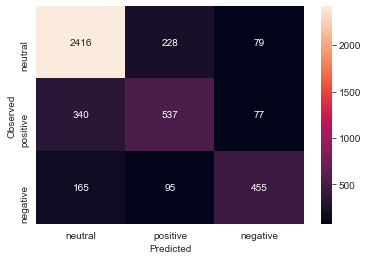

In [51]:
print('           Count Vectorization & XGBoost Confusion Matrix')
cm = confusion_matrix(y_test_cv, y_predict_xgbclass1)
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels = data['airline_sentiment'].unique() , yticklabels = data['airline_sentiment'].unique())
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.show()

In [52]:
print('Accuracy score for Count Vectorization & XGBoost is {}'.format(accuracy_score(y_test_cv, y_predict_xgbclass1)))

Accuracy score for Count Vectorization & XGBoost is 0.7759562841530054


#### Fit and evaluate model using TfIdf Vectorization

In [53]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(vectorTfIdf, y, test_size=0.3, random_state=3)

In [54]:
grid_resultXGB2 = randCVXGB.fit(X_train_tfidf, y_train_tfidf)
print(grid_resultXGB2.best_params_)

{'reg_lambda': 0.7000000000000002, 'reg_alpha': 0.6000000000000002, 'n_estimators': 450, 'max_depth': 3, 'learning_rate': 0.3699999999999999, 'booster': 'gbtree'}


In [55]:
# Final Model Tweaked by RandomizedSearchCV
xgbclass2 = grid_resultXGB2.best_estimator_.fit(X_train_tfidf, y_train_tfidf)

y_predict_xgbclass2 = xgbclass2.predict(X_test_tfidf)

           TfIdf Vectorization & XGBoost Confusion Matrix


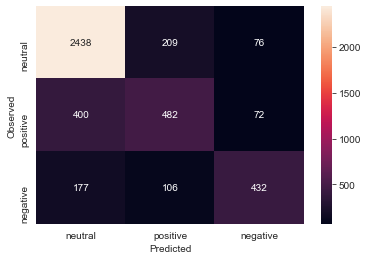

In [56]:
print('           TfIdf Vectorization & XGBoost Confusion Matrix')
cm = confusion_matrix(y_test_tfidf, y_predict_xgbclass2)
sns.heatmap(cm, annot=True,  fmt='.0f', xticklabels = data['airline_sentiment'].unique() , yticklabels = data['airline_sentiment'].unique())
plt.ylabel('Observed')
plt.xlabel('Predicted')
plt.show()

In [57]:
print('Accuracy score for TfIdf Vectorization & XGBoost is {}'.format(accuracy_score(y_test_tfidf, y_predict_xgbclass2)))

Accuracy score for TfIdf Vectorization & XGBoost is 0.7632058287795993


## Summarize your understanding of the application of Various Pre-processing and Vectorization and performance of your model on this dataset

1. Pre-precessing results in better model accuracy through:
    - Tokenization allows us focus on individual tokens/words to reduce instances that have the same contextual meaning, thereby reduing the dimension of independent tokens/variables
    - Stopword removal - has assisted with reducing occurance of curse of dimensionality on the independent variables based on text. A further addition of stopword for tokens without contextual semantics for this project (e.g. aa/yr) may result in better models' accuracy
    - Conversion to lower text ensured that context is conserved, through the various typing styles of users
    - Removal of numbers reduces the dimensionality on input variables
    - Lemmatization reduces the dimensionality on input variables, which may have inflected forms, while retaining the same meaning
    - Contractions assist in extracting tokens from inflected words with apostophes, ensuring no data loss in input variable/token counts
2. Vectorization 
    - by limiting max_features=1000, we have ensured that 1000 most frequented tokens post-pre-processing are used as independent variables for the model, reducing chances of curse of dimensionality
    - the model can be further finetuned by cross validating various values of max_features during vectorization
3. Model was cross validated using RandomizedSearchCV and hence we expect it to generalise well in production
4. Count Vectorization & XGBoost (accuracy 0.7759) performed better that TfIdf Vectorization & XGBoost (accuracy 0.7632):
    - This may be due to TfIdf assigning importance to tokens/words that do not impact sentiment in the context of airline reviews
    - Bi-gram or higher n-grams may yield a different result as they may add more context

In [58]:
finalModels = pd.DataFrame(columns=['Actual', 'Count Vectorizer Predicted', 'Tf-Idf Vectorizer Predicted'])

finalModels['Actual'] = y_test_tfidf
finalModels['Count Vectorizer Predicted'] = y_predict_xgbclass1
finalModels['Tf-Idf Vectorizer Predicted'] = y_predict_xgbclass2
finalModels.head(10).replace({0: 'negative', 1: 'neutral', 2: 'positive'})

,Actual,Count Vectorizer Predicted,Tf-Idf Vectorizer Predicted
528,neutral,neutral,neutral
14482,negative,negative,negative
8006,negative,neutral,neutral
14063,negative,negative,negative
8909,positive,positive,positive
14267,negative,negative,negative
3000,negative,negative,negative
7683,neutral,neutral,neutral
7827,positive,negative,negative
6156,negative,negative,negative
